<a href="https://colab.research.google.com/github/deep-pooja/Dynamic_Graph_Clustering/blob/main/Geometric_median.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Weiszfeld's algorithm
2. Cohen's geometric median in nearly linear time

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
def plot():
  plt.xlim(0, 149)
  plt.ylim(0, 149)
  plt.scatter(x, y, label= "points", color= "black", marker= "o", s=10)
  plt.show()

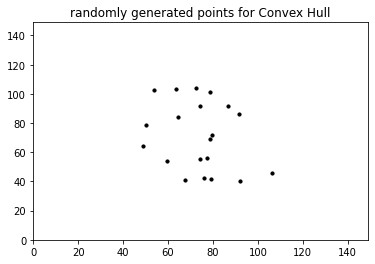

In [ ]:
x = []
y = []
n = 20

for i in range(n):
  x.append(40 + random.random()*70)
  y.append(40 + random.random()*70)
with open('/content/x.txt', 'w') as f:
    for item in x:
        f.write("%s\n" % item)
with open('/content/y.txt', 'w') as f:
    for item in y:
        f.write("%s\n" % item)
plt.title('randomly generated points for Convex Hull')
plot()

In [ ]:
X = np.column_stack((x,y))

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist, euclidean

def l1_median(X, eps=1e-6):
    """
    Computes weighted geometric median
    :param X: the list of sample points, a 2D ndarray
    :param eps: acceptable error margin
    :return: first estimate meeting eps
    """
    y = np.mean(X,0) # the geometric mean is a fare start
    while True:
        while np.any(cdist(X,[y])==0): # Euclidean distances, let's move away to avoid any null
            y +=0.1*np.ones(len(y))
        # set of weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        # new estimate is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def weighted_l1_median(X, WX, eps=1e-6):
    """
    Computes weighted geometric median
    :param X: the list of sample points, a 2D ndarray
    :param WX: the list of weights
    :param eps: acceptable error margin
    :return: first estimate meeting eps
    """
    y = np.average(X,axis=0,weights=WX)
    while True:
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
        W = np.expand_dims(WX,axis=1)/cdist(X,[y]) # element-wise operation
        y1 = np.sum(W*X,0)/np.sum(W)
        if euclidean(y,y1) < eps:
            return y1
        y = y1

In [ ]:
g = l1_median(X)
g

array([77.64112065, 82.65282125])

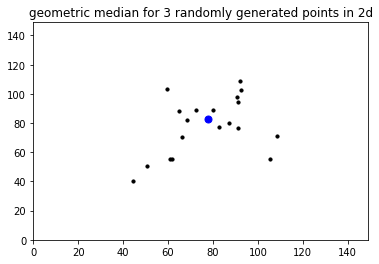

In [ ]:
plt.plot(g[0], g[1], color='blue', marker='o', markersize=7) # marking the geometric median point by color blue

plt.title('geometric median for 3 randomly generated points in 2d')
plot()

In [ ]:
#!/usr/bin/env python
"""
Description: Geometric median function implementation

"""

from math import log
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from warnings import warn

__author__ = "Deep Pooja"


def geometric_median(points: np.array, weights: np.array = None, convergence_method: str = 'vardi-zhang', convergence_threshold: float = 1e-5, iteration_limit: int = 1000, dist_measure: str = 'euclidean', scale_method=None, solver_method: str = None) -> np.array:

    # Raise errors for improper inputs

    # points errors
    if type(points) is not np.ndarray:
        raise TypeError(f"Type of points must be a numpy array; current type is {type(points)}")
    if (np.issubdtype(points.dtype, np.integer) or np.issubdtype(points.dtype, np.floating)) is False:
        raise TypeError(f"Datatype of points must be int or float; current datatype is {points.dtype}")
    if len(points.shape) != 2:
        raise ValueError(f"points must be a 2D array; currently shape is {points.shape}")

    npoint, ndim = points.shape

    if ndim < 1:
        raise ValueError(f"value of ndim must be >= 1; currently value is {ndim}")

    # weights errors
    if weights is None:
        weights = np.ones(npoint)
    else:
        if type(weights) is not np.ndarray:
            raise TypeError(f"Type of weights must be a numpy array; current type is {type(points)}")
        if (np.issubdtype(weights.dtype, np.integer) or np.issubdtype(weights.dtype, np.floating)) is False:
            raise TypeError(f"Datatype of points must be real numbers; current datatype is {points.dtype}")
        if len(weights.shape) != 1:
            raise ValueError(f"weights must be a 1D array; currently shape is {weights.shape}")
        if weights.size != npoint:
            raise ValueError(f"There must be the same number of weights as points; currently {weights.size} weights and {npoint} points")
        if np.isclose(weights, 0.0).any():
            raise ValueError("weights cannot contain any values == 0; recommend removing these points before calculation")
        if weights.sum() < 0:
            raise ValueError("the sum of the weights cannot be > 0")

    # method errors
    valid_convergence_methods = {'minimize': minimize_algorithm, 'weiszfeld': weiszfeld_algorithm, 'vardi-zhang': vardi_zhang_algorithm, 'cohen-lee': cohen_lee_algorithm}
    if convergence_method not in valid_convergence_methods:
        raise ValueError(f"Invalid convergence method given: {convergence_method} not in {set(valid_convergence_methods.keys())}")

    # convergence_threshold errors
    if type(convergence_threshold) not in (int, float):
        raise TypeError(f"Type of convergence_threshold must be int or float; currently of type {type(convergence_threshold)}")
    if convergence_threshold <= 0:
        raise ValueError(f"Value of convergence_threshold must be > 0; current value is {convergence_threshold}")

    # iteration_limit errors
    if type(iteration_limit) is not int:
        raise TypeError(f"Type of iteration_limit must be int; current type is {type(iteration_limit)}")
    if iteration_limit <= 0:
        raise ValueError(f"Value of iteration_limit must be > 0; current value is {iteration_limit}")

    # scalar_method errors
    if scale_method is not None:
        valid_scale_methods = {'min-max': MinMaxScaler, 'max-abs': MaxAbsScaler, 'standard': None}
        if scale_method not in valid_scale_methods:
            raise ValueError(f"Invalid scaling method given: {scale_method} not in {set(valid_scale_methods.keys())}")
        if scale_method == 'standard':
            if (weights < 0).any():
                raise ValueError("weights cannot contain any values < 0 when using standard scaling")
            points_mean = np.average(points, axis=0, weights=weights)
            points_var = np.average((points - points_mean[: None]) ** 2, axis=0, weights=weights)
            points_std = np.sqrt(points_var)
            points = (points - points_mean) / points_std
        else:
            scaler = valid_scale_methods[scale_method]()
            points = scaler.fit_transform(points)

    # distance_measure errors
    # Caught by scipy.spatial.distance.cdist

    # solver_method errors
    # Caught by scipy.optimize.minimize

    elif convergence_method == 'minimize':
        if solver_method == None:
            solver_method = 'Nelder-Mead'
        result = minimize_algorithm(points, weights, convergence_threshold, iteration_limit, dist_measure, solver_method)
    if convergence_method == 'weiszfeld':
        result = weiszfeld_algorithm(points, weights, convergence_threshold, iteration_limit, dist_measure)
    elif convergence_method == 'vardi-zhang':
        result = vardi_zhang_algorithm(points, weights, convergence_threshold, iteration_limit, dist_measure)
        # Note: Cohen-lee only works for euclidian distance
        # TODO: Find out which methods work for non-euclidean distance measures
        # TODO: Consider converting the whole thing to just euclidian
    elif convergence_method == 'cohen-lee':
        result = cohen_lee_algorithm(points, weights, convergence_threshold, iteration_limit, dist_measure)

    if scale_method is not None:
        if scale_method == 'standard':
            result = (result * points_std) + points_mean
        else:
            result = scaler.inverse_transform(result.reshape(1, -1))[0]

    return result


def minimize_algorithm(points: np.ndarray, weights: np.array, convergence_threshold: float, iteration_limit: int, dist_measure: str, solver_method: str) -> np.array:

    def calc_weighted_distance_score(curr_center):

        return (weights * cdist(np.array([curr_center]), points, metric=dist_measure)).sum()

    # Find the weighted centroid and set as the initial center
    curr_center = (weights[:, None] * points).sum(axis=0) / weights.sum()

    optimize_result = minimize(calc_weighted_distance_score, curr_center, method=solver_method, tol=convergence_threshold, options={'maxiter': iteration_limit})

    if optimize_result.success:
        return optimize_result.x
    else:
        raise ValueError(optimize_result.message)


def weiszfeld_algorithm(points: np.ndarray, weights: np.array, convergence_threshold: float, iteration_limit: int, dist_measure: str) -> np.array:

    # Find the weighted centroid and set as the initial center
    prev_center = (weights[:, None] * points).sum(axis=0) / weights.sum()

    for _ in range(iteration_limit):
        # Check if the current center is same as a point; weiszfeld will stop converging
        # This is a flaw in the algorithm adressed in vardi-zhang
        if np.isclose(points, prev_center).all(axis=1).any():
            return prev_center
        # Calculate the weighted distances from the current center to all points
        weighted_distances = cdist(np.array([prev_center]), points, metric=dist_measure)[0] / weights
        # Get new center prediction
        curr_center = (points / weighted_distances[:, None]).sum(axis=0) / (1.0 / weighted_distances).sum()
        # Calculate the distance between the current center and the previous center
        move_dist = cdist(np.array([curr_center]), np.array([prev_center]), metric=dist_measure)[0, 0]
        if move_dist < convergence_threshold:
            return curr_center
        prev_center = curr_center

    raise ValueError(f"Weiszfelds algorithm not able to converge within {iteration_limit} iterations")


def vardi_zhang_algorithm(points: np.ndarray, weights: np.array, convergence_threshold: float, iteration_limit: int, dist_measure: str) -> np.array:
    """
    Adaption of the weiszfeld algorithm that deals with the current center getting 'stuck' on points in the dataset
    file:///C:/Users/mattw/Downloads/SSRN-id1690502.pdf
    :param points:
    :param weights:
    :param convergence_threshold:
    :param iteration_limit:
    :param dist_measure:
    :return:
    """

    # Find the weighted centroid and set as the initial center
    prev_center = (weights[:, None] * points).sum(axis=0) / weights.sum()

    for _ in range(iteration_limit):
        # Calculate the weighted distances from the current center to all points
        weighted_distances = cdist(np.array([prev_center]), points, metric=dist_measure)[0] / weights
        # Narrow to only the non-zero weighted distances
        non_zero = ~np.isclose(weighted_distances, 0.0)
        weighted_distances = weighted_distances[non_zero]
        # Implement the process detailed in "A comparison of algorithms for multivariate L1-median"
        T = (points[non_zero] / weighted_distances[:, None]).sum(axis=0) / (1.0 / weighted_distances[:, None]).sum()
        eta = 1 if np.isclose(points, prev_center).all(axis=1).any() else 0
        R = ((points[non_zero] - prev_center) / weighted_distances[:, None]).sum(axis=0)
        diff_dist = cdist(np.array([np.zeros_like(R)]), np.array([R]), metric=dist_measure)[0, 0]
        if np.isclose(diff_dist, 0.0):
            gamma = 1
        else:
            gamma = min(1, eta / diff_dist)
        curr_center = (1 - gamma) * T + gamma * prev_center

        # Calculate the distance between the current center and the previous center
        move_dist = cdist(np.array([curr_center]), np.array([prev_center]), metric=dist_measure)[0][0]
        if move_dist < convergence_threshold:
            return curr_center
        prev_center = curr_center

    raise ValueError(f"Vardi-Zhang algorithm not able to converge within {iteration_limit} iterations")


def cohen_lee_algorithm(points: np.ndarray, weights: np.ndarray, convergence_threshold: float, iteration_limit: int, dist_measure: str) -> np.array:

    return accurate_median(points, convergence_threshold)

def accurate_median(points: np.ndarray, convergence_threshold: float):

    npoint, ndim = points.shape

    x0 = points.mean(axis=0)
    f_star_hat = cdist(np.array([x0]), points).sum()
    t_i = calc_t_i(1, f_star_hat)
    conv_thresh_c = 1 / (10 ** 15 * npoint ** 3 * t_i ** 9 * f_star_hat ** 3)
    x_i = line_search(x0, t_i, t_i, 0, conv_thresh_c)

    for i in range(1, 1000 * log(3000 * npoint / convergence_threshold)):
        conv_thresh_v = 1 / (10 ** 8 * npoint ** 2 * t_i ** 2 * f_star_hat ** 2)
        lambda_i, u_i = approx_min_eig(x_i, t_i, conv_thresh_v)
        conv_thresh_c = 1 / (10 ** 15 * npoint ** 3 * t_i ** 3 * f_star_hat ** 3)
        t_i1 = calc_t_i(i + 1, f_star_hat)
        x_i = line_search(x_i, t_i, t_i1, u_i, conv_thresh_c)
        t_i = t_i1

    return x_i

def calc_t_i(i, f_star_hat):

    return (1 + 1/600) ** (i - 1) / (400 * f_star_hat)


def approx_min_eig(point: np.ndarray, points: np.ndarray, t: float, convergence_threshold: float):

    for i, curr_point in enumerate(points):
        t ** 4 * (point - curr_point) * (point - curr_point).T
    A = t ** 4 * (-points + point) * (-points + point).T / ((1 + g_t))


    pass

def power_method(A, k):  # k is the number of iterations

    g = A.shape[0]
    x = multivariate_normal(np.array([0, 1]), mean=0, cov=1) # drawn from a d dimensional normal distribution.
    y = np.linalg.matrix_power(A, k) * x

    return y / np.linalg.norm(y)  #

def local_center(point: np.ndarray, path_parameter: float, convergence_threshold: float):

    pass

def line_search(point: np.ndarray, curr_path_param: float, next_path_param: float, bad_decision: float, convergence_threshold: float):

    pass

def one_dim_minimizer(lower_bound: float, upper_bound: float, convergence_threshold: float, oracle: float, lopschitz_bound: float):

    x = lower_bound
    y_lower = lower_bound
    y_upper = upper_bound

    for i in range(1, log((upper_bound - lower_bound) / convergence_threshold, 3 / 2)):
        z_lower = (2 * y_lower + y_upper) / 3
        z_upper = (y_lower + 2 * y_upper) / 3
        if oracle(z_lower) <= oracle(z_upper):
            y_upper = z_upper
            if oracle(z_lower) <= oracle(x):
                x = z_lower
        elif oracle(z_lower) > oracle(z_upper):
            y_lower = z_lower
            if oracle(z_upper) <= oracle(x):
                x = z_upper

    return x

def oracle(alpha):

    pass

def predict_optiomal_method(npoint, ndim, convergence_threshold):

    # TODO: Need to find time complexity estimates of methods
    methods = ["Weizfeld", "Vardi-Zhang"]

    # https://stackoverflow.com/questions/12934213/how-to-find-out-geometric-median
    weizfeld_comp = npoint * ndim / convergence_threshold
    time = []
    # Weizfeld
    # Vardi-Zhang

    return

In [ ]:
"""

"""



"""
Power method to compute approximate eigen value
"""
def power_method(A, k):

  # create an array to be returned. It has the shape of A's number of rows
  # and contains 3-tuples of singular value (float), right singular
  # vector (object), left singular vector (object).
  res = np.empty(A.shape[0], dtype=('float ,object, object'))
  m = A.shape[0]

  for i in range(m): #calculating the ith singular value and left right vectors

    #constructing ATA
    Acopy = copy.deepcopy(A) #constructs a copy of input matrix as it is
                           #necessary to preserve it for future computations
    ATA = np.transpose(Acopy).dot(Acopy) #computes ATA
    # end of ATA construction

    # We choose a random vector so that the chances of it being orthogonal
    # to the eigenvectors of the matrix are slim
    v = np.random.rand(ATA.shape[1])
    for _ in range(k): #approximates the limit with k iterations
        temp = np.dot(ATA, v) #matrix-vector multiplication between (ATA)v
        v = temp / np.linalg.norm(temp) #normalizes the vector at each iteration
    # After a sufficient amount of iterations, the changes to v will become
    # increasingly less significant, which causes v to approach the limit
    # which is the eigenvector


    # Eigen value can be calculated through a simple process. First, we
    # calculate the dot product of ATA・v. We then calculate the dot
    # product of (ATA・v)・v. By dividing by the ||v||^2 which can be
    # attained by the dot product of v・v, we get the eigenvalue. This
    # is known as Reileigh's Quotient. Since we that the eigenvalue is
    # the singular value squared, we will take the square root.
    sval = math.sqrt(np.dot(ATA, v).dot(v) / np.dot(v,v))

    # The left singular vector is obtained by \frac{1}{σ}*A・v
    u = (1/sval)*A.dot(v)

    # Creates a 3-tuple with the order required by the project writeup
    res[i] = np.asarray((sval, np.ndarray.tolist(v), np.ndarray.tolist(u)),
                        dtype=('float ,object, object'))

    # Subtracts the best rank i approximation from A and goes onto calculate
    # the (i+1)th singular value and its left and right singular vectors
    A = A - sval*(np.dot(u.reshape(5,1),(np.transpose(v).reshape(1,10))))

  return res #returns an 1D array (size m) of 3-tuples